# Imports

In [74]:
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import os, math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, silhouette_score
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error
from collections import Counter

# Set seed for reproducibility

In [2]:
np.random.seed(0)
tf.random.set_seed(0)

# Tensorflow prepereation

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Loading Data

In [4]:
with open("options.txt", 'r') as f:
    options = f.readlines()
    options = {option.split("=")[0]: option.split("=")[1].strip() for option in options}
print(options)

{'hanoi_scenario_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\Hanoi_CMH\\Scenario-1', 'RUG_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\RUG_data_5years', 'RUG_raw_csv': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_csv.csv', 'RUG_timeseries': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_timeseries.pkl', 'RUG_obfuscated': 'C:\\Users\\mjnst\\Desktop\\Thesis\\obfuscated_data.pkl'}


In [5]:
RUG = pd.read_pickle(options['RUG_obfuscated'])

In [6]:
RUG.interpolate(method='linear', inplace=True, limit=20)

In [7]:
RUG

,Location 1 - flow,Location 2 - consumption,Location 3 - consumption,Location 4 - consumption,Location 5 - consumption,Location 6 - head,Location 7 - head,Location 8 - flow,Location 9 - head,Location 10 - flow,Location 11 - head,Location 11 - flow,Location 12 - head
date,,,,,,,,,,,,,
2017-01-01 00:00:00+01:00,254.539382,1.030,NaN,2.02,0.51,87.180074,70.544564,0.737664,54.730393,80.548130,54.500049,0.0,65.575694
2017-01-01 00:01:00+01:00,208.887537,1.030,NaN,2.02,0.51,87.180689,70.542433,0.969356,54.730993,80.504579,54.495521,0.0,66.371564
2017-01-01 00:02:00+01:00,159.840131,1.030,NaN,2.02,0.51,87.181304,70.540301,11.331360,54.731593,80.456367,54.490993,0.0,66.424766
2017-01-01 00:03:00+01:00,196.639898,1.030,NaN,2.02,0.51,87.181919,70.538170,3.308890,54.732193,80.378972,54.486464,0.0,65.998265
2017-01-01 00:04:00+01:00,296.297964,1.030,NaN,2.02,0.51,87.182534,70.536038,0.304809,54.732792,80.127816,54.481936,0.0,63.804532
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-31 23:55:00+01:00,63.642857,0.084,0.0,1.56,0.48,86.617845,68.795775,0.068382,54.287846,89.818886,55.533346,0.0,70.484617
2022-10-31 23:56:00+01:00,63.930565,0.084,0.0,1.56,0.48,86.549566,68.890125,0.068355,54.288759,89.618172,55.866599,0.0,70.438112
2022-10-31 23:57:00+01:00,65.248125,0.084,0.0,1.56,0.48,86.512148,68.972139,0.068329,54.289673,89.408001,55.561931,0.0,70.394276


In [113]:
groups = RUG['Location 2 - consumption'].groupby(pd.Grouper(freq='D'))

# get the calender date of the groups
days = list(groups.first().index.strftime('%Y:%m:%d'))

gro = [groups.get_group(x).reset_index(drop=True) for x in groups.groups]

temp = pd.concat(gro, axis=1, keys=days)

temp.index = pd.date_range("00:00", "23:59", freq="1min").strftime('%H:%M')

# drop all columns of temp dataframe which contain nan values
temp.dropna(axis=1, how='any', inplace=True)

In [114]:
temp = temp[::10]

In [115]:
temp = temp.T
temp

,00:00,00:10,00:20,00:30,00:40,00:50,01:00,01:10,01:20,01:30,...,22:20,22:30,22:40,22:50,23:00,23:10,23:20,23:30,23:40,23:50
2017:01:01,1.030,1.030000,1.030000,1.030000,1.030000,1.030000,0.940000,0.940000,0.94000,0.94000,...,0.820,0.820,0.820,0.820,0.340,0.340,0.340,0.340,0.340,0.340
2017:01:02,0.250,0.250000,0.250000,0.250000,0.250000,0.250000,0.260000,0.260000,0.26000,0.26000,...,1.390,1.390,1.390,1.390,0.550,0.550,0.550,0.550,0.550,0.550
2017:01:03,0.920,1.302045,1.320959,1.320959,1.320959,1.179666,1.006653,0.918382,0.89211,0.89211,...,0.790,0.790,0.790,0.790,0.330,0.330,0.330,0.330,0.330,0.330
2017:01:04,0.270,0.270000,0.270000,0.270000,0.270000,0.270000,0.190000,0.190000,0.19000,0.19000,...,0.360,0.360,0.360,0.360,0.280,0.280,0.280,0.280,0.280,0.280
2017:01:05,0.220,0.220000,0.220000,0.220000,0.220000,0.220000,0.320000,0.320000,0.32000,0.32000,...,0.710,0.710,0.710,0.710,0.300,0.300,0.300,0.300,0.300,0.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022:10:27,0.180,0.108000,0.180000,0.192000,0.060000,0.012000,0.120000,0.000000,0.09600,0.19200,...,1.656,0.756,0.468,0.300,0.516,0.396,0.552,0.192,0.252,0.312
2022:10:28,0.312,0.144000,0.300000,0.264000,0.168000,0.168000,0.216000,0.228000,0.15600,0.14400,...,0.408,0.636,0.408,0.192,0.360,0.360,0.504,0.432,0.120,0.096
2022:10:29,0.132,0.072000,0.300000,0.240000,0.288000,0.084000,0.168000,0.060000,0.06000,0.06000,...,0.660,0.624,0.252,0.228,0.468,0.312,0.084,0.300,0.552,0.120
2022:10:30,0.516,0.084000,0.084000,0.144000,0.168000,0.072000,0.360000,0.360000,0.36000,0.36000,...,0.252,0.324,2.064,0.324,0.312,0.216,0.408,0.720,0.264,0.312


In [58]:
#split the data into train and test set based on the columns
# train_percentage = 0.8
# train_size = int(len(temp.columns) * train_percentage)
# train = temp.iloc[:, :train_size]
# test = temp.iloc[:, train_size:]

In [151]:
train_percentage = 0.8
train_size = int(len(temp.index) * train_percentage)
train = temp[:train_size]
test = temp[train_size:]

In [154]:
# scaler = MinMaxScaler(feature_range=(0, 1))

# scaled_list_train = [train[col] for col in train]
# scaled_list_train = scaler.fit_transform(scaled_list_train)

# scaled_list_test = [test[col] for col in test]
# scaled_list_test = scaler.transform(scaled_list_test)

In [155]:
scaler = StandardScaler()
scaled_list_train = scaler.fit_transform(train)
scaled_list_test = scaler.transform(test)

Shape before PCA:  (1702, 144)
Shape after PCA:  (1702, 9)


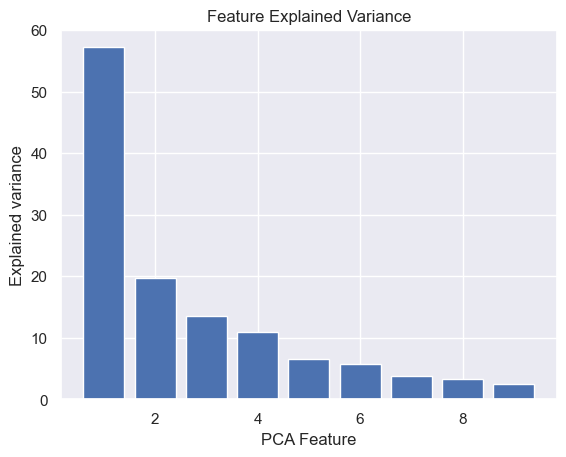

In [156]:
sns.set()
 
# Reduce from 4 to 3 features with PCA
# pca = PCA(n_components=cluster_count)
pca = PCA(n_components=0.85, svd_solver='full')
 
# Fit and transform data
pca_features = pca.fit_transform(scaled_list_train)
 

print('Shape before PCA: ', scaled_list_train.shape)
print('Shape after PCA: ', pca_features.shape)

pca_df = pd.DataFrame(
    data=pca_features)

# Bar plot of explained_variance  
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

In [157]:
# wcss = []
# silhouette_scores = []

# for i in range(1,10):
#     print(i)
#     kmeans_pca = TimeSeriesKMeans(n_clusters=i, metric="dtw", n_jobs=-1).fit(pca_features)
#     wcss.append(kmeans_pca.inertia_)
#     try:
#         silhouette_scores.append(silhouette_score(pca_features, kmeans_pca.labels_, n_jobs=-1))
#     except:
#         silhouette_scores.append(0)

1
2
3
4
5
6
7
8
9


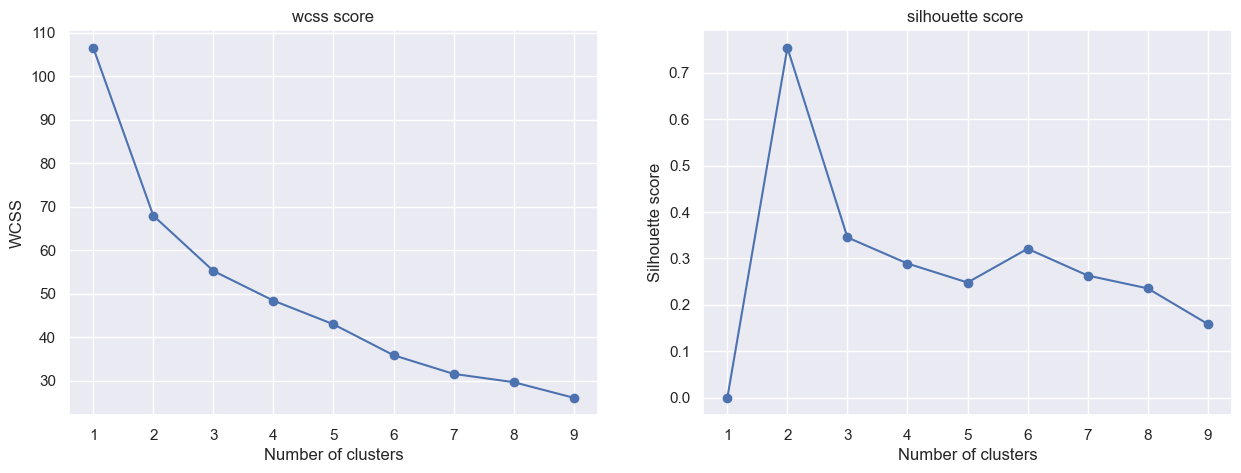

In [162]:
# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(range(1,10), wcss, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.title(f'wcss score')
# plt.subplot(1,2,2)
# plt.plot(range(1,10), silhouette_scores, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Silhouette score')
# plt.title(f'silhouette score ')
# plt.show()

In [172]:
kmeans_pca = TimeSeriesKMeans(n_clusters=3, metric="dtw", n_jobs=-1).fit(pca_features)
train_pca_features = kmeans_pca.predict(scaled_list_train)
test_pca_features = kmeans_pca.predict(scaled_list_test)


c:\Users\mjnst\anaconda3\envs\thesis\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1702 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
c:\Users\mjnst\anaconda3\envs\thesis\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 426 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [173]:
counts = dict(Counter(train_pca_features))
counts

{0: 1608, 2: 89, 1: 5}

In [196]:
n_future = 1
n_past = 10

trainX = []
trainY = []
for i in range(n_past, len(scaled_list_train)-n_future+1):
    trainX.append(scaled_list_train[i - n_past:i, 0:scaled_list_train.shape[1]])
    trainY.append(scaled_list_train[i + n_future - 1:i + n_future, 0:scaled_list_train.shape[1]])

testX = []
testY = []
for i in range(n_past, len(scaled_list_test)-n_future+1):
    testX.append(scaled_list_test[i - n_past:i, 0:scaled_list_test.shape[1]])
    testY.append(scaled_list_test[i + n_future - 1:i + n_future, 0:scaled_list_test.shape[1]])

In [198]:
trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

In [184]:
trainX.shape, trainY.shape

((1692, 10, 144), (1692, 1, 144))

In [199]:
scaled_list_train[np.where(train_pca_features == 0)].T.shape

(144, 1608)

In [200]:
# select all columns from scaled_list_train which are in cluster 0 using numpy
cluster0 = scaled_list_train[np.where(train_pca_features == 0)].T
cluster0.shape

(144, 1608)

In [201]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
look_back = n_past

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.fit(trainX, trainY, epochs=100, verbose=2, callbacks=[callback], batch_size=32)

Epoch 1/100
53/53 - 2s - loss: 1.0362 - mse: 1.0371 - 2s/epoch - 47ms/step
Epoch 2/100
53/53 - 0s - loss: 1.0139 - mse: 1.0134 - 432ms/epoch - 8ms/step
Epoch 3/100
53/53 - 1s - loss: 1.0125 - mse: 1.0124 - 542ms/epoch - 10ms/step
Epoch 4/100
53/53 - 0s - loss: 1.0110 - mse: 1.0114 - 465ms/epoch - 9ms/step
Epoch 5/100
53/53 - 0s - loss: 1.0089 - mse: 1.0097 - 449ms/epoch - 8ms/step
Epoch 6/100
53/53 - 0s - loss: 1.0098 - mse: 1.0077 - 401ms/epoch - 8ms/step
Epoch 7/100
53/53 - 0s - loss: 1.0082 - mse: 1.0090 - 426ms/epoch - 8ms/step
Epoch 8/100
53/53 - 0s - loss: 1.0101 - mse: 1.0084 - 406ms/epoch - 8ms/step
Epoch 9/100
53/53 - 0s - loss: 1.0070 - mse: 1.0072 - 373ms/epoch - 7ms/step
Epoch 10/100
53/53 - 0s - loss: 1.0082 - mse: 1.0096 - 382ms/epoch - 7ms/step
Epoch 11/100
53/53 - 0s - loss: 1.0084 - mse: 1.0090 - 415ms/epoch - 8ms/step
Epoch 12/100
53/53 - 0s - loss: 1.0082 - mse: 1.0087 - 405ms/epoch - 8ms/step


In [202]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

13/13 [==============================] - 0s 5ms/step


In [219]:
testPredict

array([[-0.07295735],
       [ 0.04306912],
       [ 0.05070404],
       [-0.00233869],
       [ 0.10380144],
       [ 0.07419956],
       [-0.10205051],
       [-0.26055136],
       [-0.2352556 ],
       [-0.12087405],
       [-0.03572369],
       [-0.15461157],
       [-0.06651999],
       [ 0.05718603],
       [-0.1178814 ],
       [-0.00726658],
       [-0.01738876],
       [-0.33817348],
       [-0.34513032],
       [-0.22466101],
       [-0.15552896],
       [-0.08710274],
       [-0.05580788],
       [ 0.04208854],
       [ 0.11591195],
       [-0.03830712],
       [-0.12775174],
       [ 0.00596165],
       [ 0.06069136],
       [-0.02735829],
       [-0.2509683 ],
       [-0.19052094],
       [ 0.06985543],
       [ 0.03881413],
       [ 0.08359698],
       [-0.16564776],
       [-0.090491  ],
       [ 0.09676517],
       [-0.02303448],
       [ 0.19273008],
       [ 0.24928331],
       [ 0.16057149],
       [-0.02309717],
       [ 0.00116452],
       [-0.31871098],
       [-0

In [220]:
train_copy = np.repeat(trainPredict, scaled_list_train.shape[1], axis=-1)
test_copy = np.repeat(testPredict, scaled_list_test.shape[1], axis=-1)

In [221]:
train_copy = scaler.inverse_transform(train_copy)[:,0]
test_copy = scaler.inverse_transform(test_copy)[:,0]

In [241]:
np.sqrt(mean_squared_error(testPredict.reshape(-1), test.to_numpy().flatten()))

ValueError: Found input variables with inconsistent numbers of samples: [416, 61344]